# Mini Project: Monte Carlo Simulation for Financial Risk Assessment

## Objective

This mini-project will guide students through the implementation of a Monte Carlo simulation to estimate financial risk using advanced random number generation techniques. By completing this project, students will apply pseudo-random and quasi-random numbers, variance reduction methods, and numerical approximations to assess the Value at Risk (VaR) of a portfolio.

## Problem Statement

You are a quantitative analyst working for a financial institution. Your task is to estimate the Value at Risk (VaR) of a stock portfolio using Monte Carlo simulations. The risk estimation should incorporate techniques such as:

- Pseudo-random and quasi-random number generation
- Antithetic variance reduction
- Taylor series approximations
- Convergence analysis

## Steps to Complete the Project



### Step 1: Data Initialization

1. Simulate the daily return of a stock using a normal distribution with a given mean and standard deviation.
2. Implement a pseudo-random number generator (PRNG) to generate these stock returns.
3. Compare the output with a quasi-random number generator (QRNG) using a Sobol sequence.


The formula for daily returns is:
 $$r_t = \mu + \sigma \cdot Z$$
Where:
* $r_t =$ daily return at time $t$
* $\mu =$ mean return
* $\sigma =$ standard deviation of returns
* $Z =$ random variable form a standard normal distribution

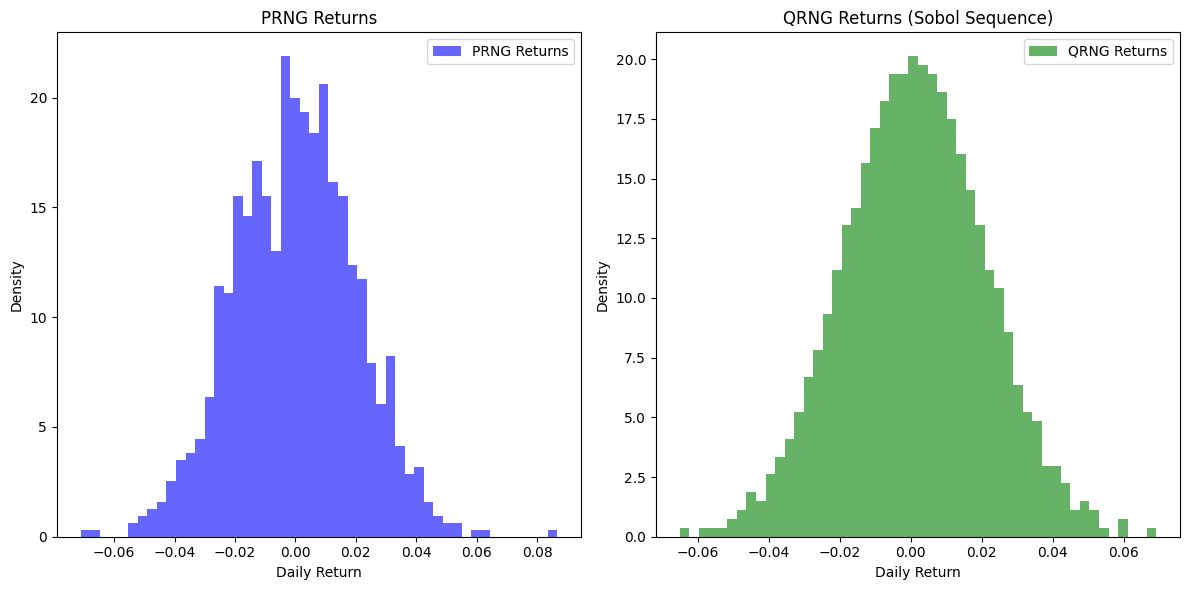

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc, norm

mu = 0.001  # Mean daily return 
sigma = 0.02  # Standard deviation of daily returns 
n_samples = 1000  # Number of samples to generate

# Daily returns - PRNG 
prng_returns = np.random.normal(mu, sigma, n_samples)

# Daily returns - QRNG 
sobol_engine = qmc.Sobol(d=1, scramble=True)  # d=1 for 1-dimensional sequence
sobol_samples = sobol_engine.random(n_samples)
# Transform Sobol samples to normal distribution using inverse CDF
qrng_returns = mu + sigma * norm.ppf(sobol_samples).flatten()

# Compare 
plt.figure(figsize=(12, 6))

# Plot PRNG returns
plt.subplot(1, 2, 1)
plt.hist(prng_returns, bins=50, density=True, alpha=0.6, color='blue', label='PRNG Returns')
plt.title('PRNG Returns')
plt.xlabel('Daily Return')
plt.ylabel('Density')
plt.legend()

# Plot QRNG returns
plt.subplot(1, 2, 2)
plt.hist(qrng_returns, bins=50, density=True, alpha=0.6, color='green', label='QRNG Returns')
plt.title('QRNG Returns (Sobol Sequence)')
plt.xlabel('Daily Return')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()

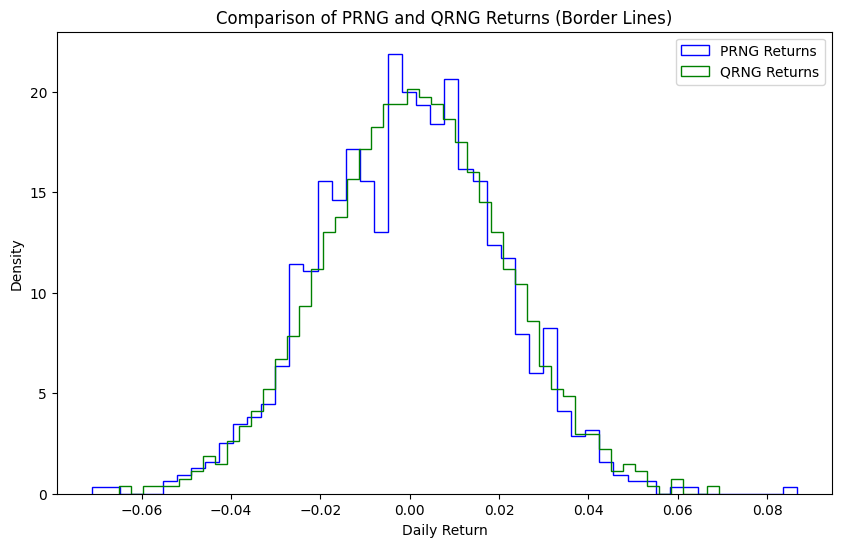

In [10]:
plt.figure(figsize=(10, 6))
plt.hist(prng_returns, bins=50, density=True, histtype='step', color='blue', label='PRNG Returns')
plt.hist(qrng_returns, bins=50, density=True, histtype='step', color='green', label='QRNG Returns')
plt.title('Comparison of PRNG and QRNG Returns (Border Lines)')
plt.xlabel('Daily Return')
plt.ylabel('Density')
plt.legend()
plt.show()


### Step 2: Monte Carlo Simulation for Stock Price Evolution

1. Simulate stock price paths using the Geometric Brownian Motion (GBM) model:

   
   $$S_t = S_0 \exp\left( (\mu - \frac{\sigma^2}{2}) t + \sigma W_t \right)$$
   

   where $W_t$ is a Wiener process.

2. Generate multiple stock price paths using both PRNG and QRNG methods.
3. Visualize the simulated stock price paths.




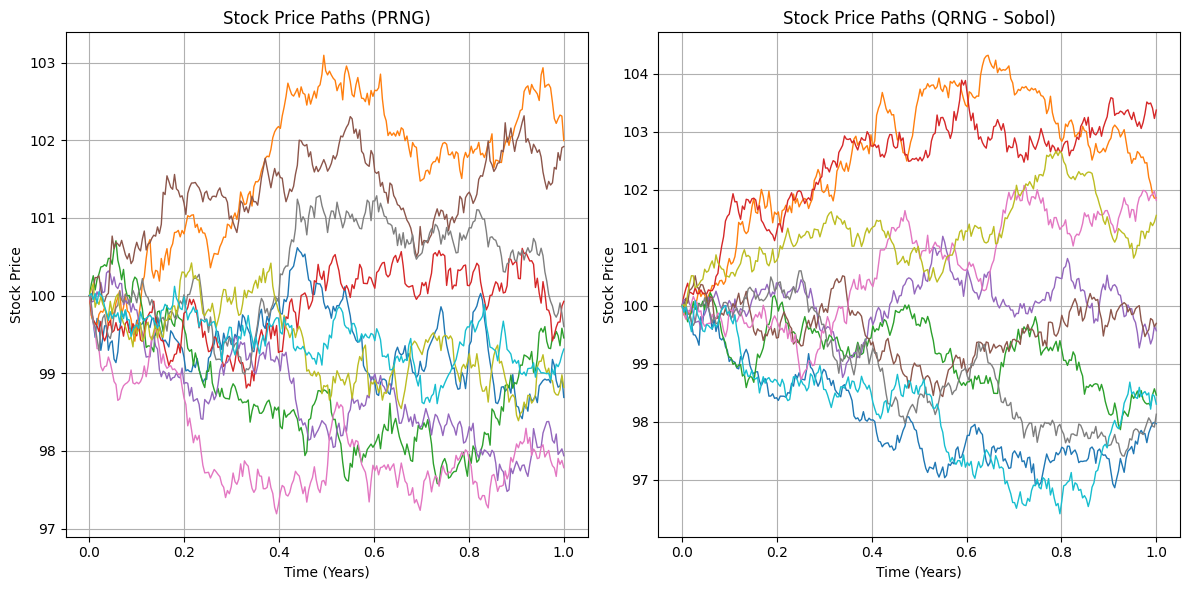

In [11]:
S0 = 100  # Stock price
T = 1  # 1 year
n_steps = 252  # trading days in a year
n_paths = 10  # Paths 

t = np.linspace(0, T, n_steps)

# Simulate stock price - GBM
def simulate_gbm(S0, mu, sigma, t, n_paths, use_qrng=False):
    n_steps = len(t)
    dt = t[1] - t[0]  # Time step size
    paths = np.zeros((n_steps, n_paths))
    paths[0, :] = S0 

    if use_qrng:
        # Sobol for QRNG
        sobol_engine = qmc.Sobol(d=n_steps-1, scramble=True)
        sobol_samples = sobol_engine.random(n_paths)
        Z = norm.ppf(sobol_samples).T  # Transform to standard normal and transpose to match dimensions
    else:
        # PRNG
        Z = np.random.normal(0, 1, (n_steps-1, n_paths))

    for i in range(1, n_steps):
        drift = (mu - 0.5 * sigma**2) * dt
        diffusion = sigma * np.sqrt(dt) * Z[i-1, :]
        paths[i, :] = paths[i-1, :] * np.exp(drift + diffusion)

    return paths

# PRNG
prng_paths = simulate_gbm(S0, mu, sigma, t, n_paths, use_qrng=False)

# QRNG
qrng_paths = simulate_gbm(S0, mu, sigma, t, n_paths, use_qrng=True)

plt.figure(figsize=(12, 6))

# PRNG 
plt.subplot(1, 2, 1)
for i in range(n_paths):
    plt.plot(t, prng_paths[:, i], lw=1)
plt.title('Stock Price Paths (PRNG)')
plt.xlabel('Time (Years)')
plt.ylabel('Stock Price')
plt.grid(True)

# Plot QRNG paths
plt.subplot(1, 2, 2)
for i in range(n_paths):
    plt.plot(t, qrng_paths[:, i], lw=1)
plt.title('Stock Price Paths (QRNG - Sobol)')
plt.xlabel('Time (Years)')
plt.ylabel('Stock Price')
plt.grid(True)

plt.tight_layout()
plt.show()

### Step 3: Estimating Value at Risk (VaR)

1. Compute portfolio returns from the simulated stock prices.
2. Estimate the 95% and 99% VaR using both historical simulation and Monte Carlo methods.
3. Implement antithetic variance reduction to improve estimation accuracy.
4. Compare VaR estimates using pseudo-random and quasi-random methods.



In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import qmc
import warnings
warnings.filterwarnings("ignore")






# ------------ -----------------------------------------------------
# Parámetros de la simulación
# -----------------------------------------------------------------
# - S0: Precio inicial del activo.
# - T: Horizonte temporal de la simulación (en años).
# - n_steps: Número de intervalos (días de trading) dentro del horizonte T.
# - n_paths: Número total de trayectorias (simulaciones) que se generarán.
# - mu: Rentabilidad esperada anual del activo.
# - sigma: Volatilidad anual del activo.
# - t: Vector de tiempos, dividido uniformemente desde 0 hasta T.
S0 = 100      # Precio inicial
T = 1         # Horizonte temporal: 1 año
n_steps = 252 # Número de días de trading en un año
n_paths = 1000  # Número de trayectorias a simular
mu = 0.1      # Rentabilidad esperada (10%)
sigma = 0.2   # Volatilidad (20%)
t = np.linspace(0, T, n_steps)  # Vector de tiempos (0, T) con n_steps intervalos

# -----------------------------------------------------------------
# Función de simulación GBM (Movimiento Browniano Geométrico)
# -----------------------------------------------------------------
def simulate_gbm(S0, mu, sigma, t, n_paths, use_qrng=False):
    """
    Simula trayectorias de precios usando el modelo GBM.

    Pasos realizados:
    - Calcular el tamaño del paso temporal: dt = t[1] - t[0].
    - Inicializar un arreglo 'paths' para almacenar las trayectorias.
      * Dimensión: (n_steps, n_paths)
      * El primer valor de cada trayectoria es S0.
    - Generar números aleatorios:
      * Si use_qrng es True:
        - Se usan números cuasialeatorios mediante la secuencia de Sobol.
        - Se generan muestras uniformes que se transforman a valores de una
          distribución normal estándar mediante la función norm.ppf.
      * Si use_qrng es False:
        - Se generan números pseudoaleatorios con np.random.normal.
    - Iterar a través de los pasos de tiempo para actualizar el precio:
      * Calcular el "drift" (componente determinista): (mu - 0.5 * sigma^2)*dt.
      * Calcular la "difusión" (componente aleatoria): sigma * sqrt(dt) * Z.
      * Actualizar el precio: S[i] = S[i-1] * exp(drift + diffusion).

    Retorna:
    - paths: Un arreglo 2D con las trayectorias simuladas.
    """
    n_steps = len(t)
    dt = t[1] - t[0]
    paths = np.zeros((n_steps, n_paths))  # - Inicialización del arreglo de trayectorias.
    paths[0, :] = S0  # - Se asigna S0 a todas las trayectorias en el tiempo 0.

    # - Generación de números aleatorios:
    if use_qrng:
        # • Se utiliza el generador Sobol para números cuasialeatorios.
        sobol_engine = qmc.Sobol(d=n_steps-1, scramble=True)
        sobol_samples = sobol_engine.random(n_paths)
        # • Se transforma la muestra uniforme a distribución normal y se transpone:
        Z = norm.ppf(sobol_samples).T  # Forma: (n_steps-1, n_paths)
    else:
        # • Generación de números pseudoaleatorios (distribución normal estándar).
        Z = np.random.normal(0, 1, (n_steps-1, n_paths))

    # - Actualización de los precios en cada paso de tiempo:
    for i in range(1, n_steps):
        drift = (mu - 0.5 * sigma**2) * dt          # Cálculo del drift.
        diffusion = sigma * np.sqrt(dt) * Z[i-1, :]   # Cálculo de la difusión.
        # • Fórmula del GBM: S(t+dt) = S(t) * exp(drift + diffusion)
        paths[i, :] = paths[i-1, :] * np.exp(drift + diffusion)
    return paths

# -----------------------------------------------------------------
# Función de simulación GBM con reducción de varianza antitética
# -----------------------------------------------------------------
def simulate_gbm_antithetic(S0, mu, sigma, t, n_paths, use_qrng=False):
    """
    Simula trayectorias GBM utilizando la técnica antitética para reducir la varianza.

    Pasos realizados:
    - Verificar que n_paths sea par para formar pares antitéticos.
    - Calcular la mitad del número de trayectorias: half_paths = n_paths // 2.
    - Generar números aleatorios para half_paths trayectorias:
      * Si use_qrng es True, usar la secuencia de Sobol y transformarlos.
      * Si use_qrng es False, usar np.random.normal.
    - Generar la versión antitética invirtiendo el signo de los números generados.
    - Concatenar las dos matrices (original y antitética) para obtener n_paths trayectorias.
    - Actualizar los precios utilizando la misma fórmula GBM.

    Retorna:
    - paths: Un arreglo 2D con las trayectorias simuladas usando antitética.
    """
    # - Asegurarse de que n_paths sea par:
    half_paths = n_paths // 2
    n_steps = len(t)
    dt = t[1] - t[0]
    paths = np.zeros((n_steps, n_paths))
    paths[0, :] = S0  # Inicializar precios en el tiempo 0.

    # - Generar números aleatorios para la mitad de las trayectorias:
    if use_qrng:
        sobol_engine = qmc.Sobol(d=n_steps-1, scramble=True)
        sobol_samples = sobol_engine.random(half_paths)
        Z_half = norm.ppf(sobol_samples).T
    else:
        Z_half = np.random.normal(0, 1, (n_steps-1, half_paths))
    
    # - Crear la versión antitética:
    Z_antithetic = -Z_half  # Se invierte el signo de cada muestra.
    # - Combinar las muestras originales y antitéticas:
    Z = np.concatenate([Z_half, Z_antithetic], axis=1)

    # - Actualización de precios para cada paso:
    for i in range(1, n_steps):
        drift = (mu - 0.5 * sigma**2) * dt
        diffusion = sigma * np.sqrt(dt) * Z[i-1, :]
        paths[i, :] = paths[i-1, :] * np.exp(drift + diffusion)
    return paths

# -----------------------------------------------------------------
# Simulación de trayectorias de precios
# -----------------------------------------------------------------
# - Se generan trayectorias con diferentes métodos:
#   • PRNG: Usando números pseudoaleatorios.
#   • QRNG: Usando números cuasialeatorios (Sobol).
#   • Antitético (PRNG y QRNG): Usando la técnica de reducción de varianza.
prng_paths = simulate_gbm(S0, mu, sigma, t, n_paths, use_qrng=False)
qrng_paths = simulate_gbm(S0, mu, sigma, t, n_paths, use_qrng=True)
prng_paths_anti = simulate_gbm_antithetic(S0, mu, sigma, t, n_paths, use_qrng=False)
qrng_paths_anti = simulate_gbm_antithetic(S0, mu, sigma, t, n_paths, use_qrng=True)

# -----------------------------------------------------------------
# Función para calcular rendimientos de cartera
# -----------------------------------------------------------------
def compute_returns(paths):
    """
    Calcula el rendimiento total de cada trayectoria.
    
    Fórmula utilizada:
      - Rendimiento = (Precio final / Precio inicial) - 1
    Retorna un arreglo con los rendimientos de cada simulación.
    """
    returns = paths[-1, :] / paths[0, :] - 1
    return returns

# - Calcular rendimientos para cada conjunto de trayectorias:
returns_prng = compute_returns(prng_paths)
returns_qrng = compute_returns(qrng_paths)
returns_prng_anti = compute_returns(prng_paths_anti)
returns_qrng_anti = compute_returns(qrng_paths_anti)

# -----------------------------------------------------------------
# Estimación del VaR: Método de Simulación Histórica
# -----------------------------------------------------------------
def var_historical(returns, confidence):
    """
    Estima el Value at Risk (VaR) usando el método histórico.

    Procedimiento:
    - Determinar el percentil a partir del nivel de confianza:
      * Por ejemplo, para un 95% de confianza, se utiliza el percentil 5.
    - El VaR se define como la pérdida (valor negativo) que no se espera superar.
    
    Parámetros:
      - returns: Arreglo de rendimientos simulados.
      - confidence: Nivel de confianza (por ejemplo, 95 o 99).
    
    Retorna:
      - VaR estimado en forma de valor negativo.
    """
    percentile = 100 - confidence  # Ejemplo: para 95% => 100 - 95 = 5
    var = -np.percentile(returns, percentile)
    return var

# - Calcular el VaR histórico para distintos niveles de confianza:
var95_hist_prng = var_historical(returns_prng, 95)
var99_hist_prng = var_historical(returns_prng, 99)
var95_hist_qrng = var_historical(returns_qrng, 95)
var99_hist_qrng = var_historical(returns_qrng, 99)
var95_hist_prng_anti = var_historical(returns_prng_anti, 95)
var99_hist_prng_anti = var_historical(returns_prng_anti, 99)
var95_hist_qrng_anti = var_historical(returns_qrng_anti, 95)
var99_hist_qrng_anti = var_historical(returns_qrng_anti, 99)

# -----------------------------------------------------------------
# Estimación del VaR: Método Monte Carlo (asumiendo distribución normal)
# -----------------------------------------------------------------
def var_montecarlo(returns, confidence):
    """
    Estima el Value at Risk (VaR) asumiendo que los rendimientos siguen una distribución normal.

    Pasos:
    - Calcular la media (mu_ret) y la desviación estándar (sigma_ret) de los rendimientos.
    - Obtener el cuantil z correspondiente a la cola inferior:
      * Por ejemplo, para 95% de confianza, se utiliza el cuantil para el 5% (norm.ppf(0.05)).
    - Calcular el VaR usando la fórmula:
      VaR = -(mu_ret + z * sigma_ret)
    
    Retorna:
      - VaR calculado, expresado como un valor negativo (pérdida).
    """
    mu_ret = np.mean(returns)
    sigma_ret = np.std(returns)
    # - Obtener el cuantil correspondiente:
    z = norm.ppf(1 - confidence/100)
    var = -(mu_ret + z * sigma_ret)
    return var

# - Calcular el VaR usando el método Monte Carlo para diferentes conjuntos:
var95_mc_prng = var_montecarlo(returns_prng, 95)
var99_mc_prng = var_montecarlo(returns_prng, 99)
var95_mc_qrng = var_montecarlo(returns_qrng, 95)
var99_mc_qrng = var_montecarlo(returns_qrng, 99)
var95_mc_prng_anti = var_montecarlo(returns_prng_anti, 95)
var99_mc_prng_anti = var_montecarlo(returns_prng_anti, 99)
var95_mc_qrng_anti = var_montecarlo(returns_qrng_anti, 95)
var99_mc_qrng_anti = var_montecarlo(returns_qrng_anti, 99)

# -----------------------------------------------------------------
# Mostrar Resultados
# -----------------------------------------------------------------
# - Se imprimen los resultados del VaR calculados con ambos métodos
#   para cada técnica de simulación:
print("=== PRNG ===")
print("Histórica:   VaR 95% = {:.2f}%, VaR 99% = {:.2f}%".format(var95_hist_prng*100, var99_hist_prng*100))
print("Monte Carlo: VaR 95% = {:.2f}%, VaR 99% = {:.2f}%".format(var95_mc_prng*100, var99_mc_prng*100))

print("\n=== QRNG (Sobol) ===")
print("Histórica:   VaR 95% = {:.2f}%, VaR 99% = {:.2f}%".format(var95_hist_qrng*100, var99_hist_qrng*100))
print("Monte Carlo: VaR 95% = {:.2f}%, VaR 99% = {:.2f}%".format(var95_mc_qrng*100, var99_mc_qrng*100))

print("\n=== Con Reducción de Varianza Antitética ===")
print("PRNG Antitético - Histórica:   VaR 95% = {:.2f}%, VaR 99% = {:.2f}%".format(var95_hist_prng_anti*100, var99_hist_prng_anti*100))
print("PRNG Antitético - Monte Carlo: VaR 95% = {:.2f}%, VaR 99% = {:.2f}%".format(var95_mc_prng_anti*100, var99_mc_prng_anti*100))
print("QRNG Antitético - Histórica:   VaR 95% = {:.2f}%, VaR 99% = {:.2f}%".format(var95_hist_qrng_anti*100, var99_hist_qrng_anti*100))
print("QRNG Antitético - Monte Carlo: VaR 95% = {:.2f}%, VaR 99% = {:.2f}%".format(var95_mc_qrng_anti*100, var99_mc_qrng_anti*100))



=== PRNG ===
Histórica:   VaR 95% = 21.65%, VaR 99% = 31.39%
Monte Carlo: VaR 95% = 26.51%, VaR 99% = 41.60%

=== QRNG (Sobol) ===
Histórica:   VaR 95% = 22.11%, VaR 99% = 33.74%
Monte Carlo: VaR 95% = 27.23%, VaR 99% = 42.92%

=== Con Reducción de Varianza Antitética ===
PRNG Antitético - Histórica:   VaR 95% = 20.78%, VaR 99% = 30.73%
PRNG Antitético - Monte Carlo: VaR 95% = 25.84%, VaR 99% = 40.89%
QRNG Antitético - Histórica:   VaR 95% = 23.08%, VaR 99% = 32.60%
QRNG Antitético - Monte Carlo: VaR 95% = 27.31%, VaR 99% = 43.04%


### Step 4: Taylor Series Approximation for Risk Adjustment
1. Use a second-order Taylor series expansion to approximate the portfolio's risk exposure.
2. Analyze the effect of approximation on risk estimation.
3. Compare results with the direct computation approach.




Expansión de Taylor de la función de riesgo (5%): [-7.36406245e+00 -4.61828084e-02 -3.53960041e+00 -1.23800389e+01
 -3.88847820e+01 -3.59795121e+01 -7.22593819e+00 -3.46034342e-02
 -2.13027692e+01 -5.57522626e+00 -1.40044053e+01 -6.45881526e-01
 -8.66202127e+01 -1.98045632e+01 -9.29604619e+01]
Expansión de Taylor de la función de riesgo (1%): [ 2.15791249 -0.03801871  0.94093676  3.49129325 11.1848717  10.34025432
  2.11696388 -0.04288216  6.0773861   1.52596236  3.96156899  0.1179989
 25.08033504  5.83381896 27.34173775]


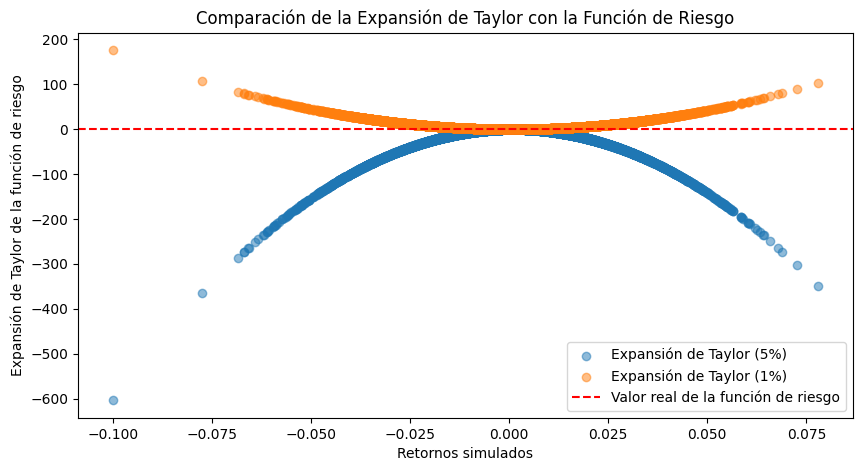

In [17]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Parámetros de la simulación
num_simulations = 10000  # Número de simulaciones
mu = 0.001  # Retorno esperado diario
sigma = 0.02  # Desviación estándar (esto debe ser definido)

returns = np.random.normal(mu, sigma, num_simulations)

plt.figure(figsize=(10, 5))
percentiles = [5, 1]  # Los percentiles que queremos calcular

for percentile in percentiles:

    def risk_function(theta):
        '''
        Calcula el percentil p de los retornos simulados con una media theta.
        La función de riesgo se evalúa como el percentil de los retornos simulados para una media dada theta.
        Esta función toma un valor de theta (media de los retornos simulados) y calcula el percentil p
        de los retornos simulados generados con una distribución normal.
        '''
        simulated_returns = np.random.normal(theta, sigma, num_simulations)
        return np.percentile(simulated_returns, percentile)

    # Aproximación de Taylor de segundo orden en torno a mu (theta_0)
    delta_theta = 0.0001  # Pequeña variación para calcular derivadas

    # Primera derivada de la función de riesgo (aproximación numérica)
    '''
    La primera derivada de la función de riesgo f'(θ) nos da la tasa de cambio del percentil
    respecto a cambios pequeños en la media de los retornos. La aproximación numérica de la derivada
    se calcula utilizando la fórmula de diferencia finita:
    
    f'(θ) ≈ (f(θ + Δθ) - f(θ)) / Δθ
    
    Aquí, Δθ es un valor pequeño que representa la variación en la media, y f(θ) es el valor de la función de riesgo.
    '''
    risk_prime = (risk_function(mu + delta_theta) - risk_function(mu)) / delta_theta

    # Segunda derivada de la función de riesgo (aproximación numérica)
    '''
    La segunda derivada de la función de riesgo f''(θ) nos da la curvatura de la función, es decir,
    cómo cambia la tasa de cambio de la función de riesgo respecto a pequeños cambios en la media de los retornos.
    Se calcula mediante la fórmula de diferencia finita de segundo orden:
    
    f''(θ) ≈ (f(θ + Δθ) - 2f(θ) + f(θ - Δθ)) / (Δθ^2)
    
    Esta derivada nos ayuda a entender cómo se comporta la función de riesgo cerca de la media mu.
    '''
    risk_double_prime = (risk_function(mu + delta_theta) - 2 * risk_function(mu) + risk_function(mu - delta_theta)) / (delta_theta ** 2)

    # Expansión de Taylor de segundo orden aplicada a la función de riesgo
    '''
    La expansión de Taylor de segundo orden de una función f(θ) alrededor de un punto θ_0 (en este caso mu) se expresa como:

    f(θ) ≈ f(θ_0) + f'(θ_0)(θ - θ_0) + 0.5 * f''(θ_0)(θ - θ_0)^2
    
    Esta aproximación utiliza los valores de la función en θ_0, su primera derivada y su segunda derivada para estimar
    el valor de f(θ) en puntos cercanos a θ_0. En este caso, θ_0 es mu, y estamos aproximando la función de riesgo
    para diferentes valores de los retornos simulados.

    La expansión de Taylor permite aproximar el percentil de los retornos cuando se tiene una pequeña variación en la media
    y proporciona una forma eficiente de calcular el riesgo sin necesidad de generar simulaciones adicionales.
    
    **1.** Este es el uso de la expansión de Taylor de segundo orden para aproximar la exposición al riesgo del portafolio.
    '''
    risk_taylor = risk_function(mu) + risk_prime * (returns - mu) + 0.5 * risk_double_prime * (returns - mu) ** 2

    print("Expansión de Taylor de la función de riesgo ({}%):".format(percentile), risk_taylor[::700])  # Mostramos solo los primeros 10 valores

    # Gráfica de la expansión de Taylor vs valores simulados
    '''
    **2.** El gráfico ayuda a analizar el efecto de la aproximación sobre la estimación del riesgo,
    mostrando cómo la expansión de Taylor se ajusta a los valores reales de la función de riesgo.
    '''
    plt.scatter(returns, risk_taylor, alpha=0.5, label='Expansión de Taylor ({}%)'.format(percentile))

# Comparación con la estimación directa
'''
**3.** La línea horizontal roja en el gráfico representa el valor real de la función de riesgo para la media mu,
lo que nos permite comparar los resultados de la expansión de Taylor con el cálculo directo de la función de riesgo.
'''
plt.axhline(y=risk_function(mu), color='r', linestyle='--', label='Valor real de la función de riesgo')
plt.xlabel('Retornos simulados')
plt.ylabel('Expansión de Taylor de la función de riesgo')
plt.legend()
plt.title('Comparación de la Expansión de Taylor con la Función de Riesgo')
plt.show()


### Step 5: Convergence Analysis and Final Report

1. Study the convergence behavior of Monte Carlo estimates by increasing the number of simulations.
2. Plot error vs. number of simulations to assess efficiency.
3. Write a summary report discussing findings, methodology, and computational performance.



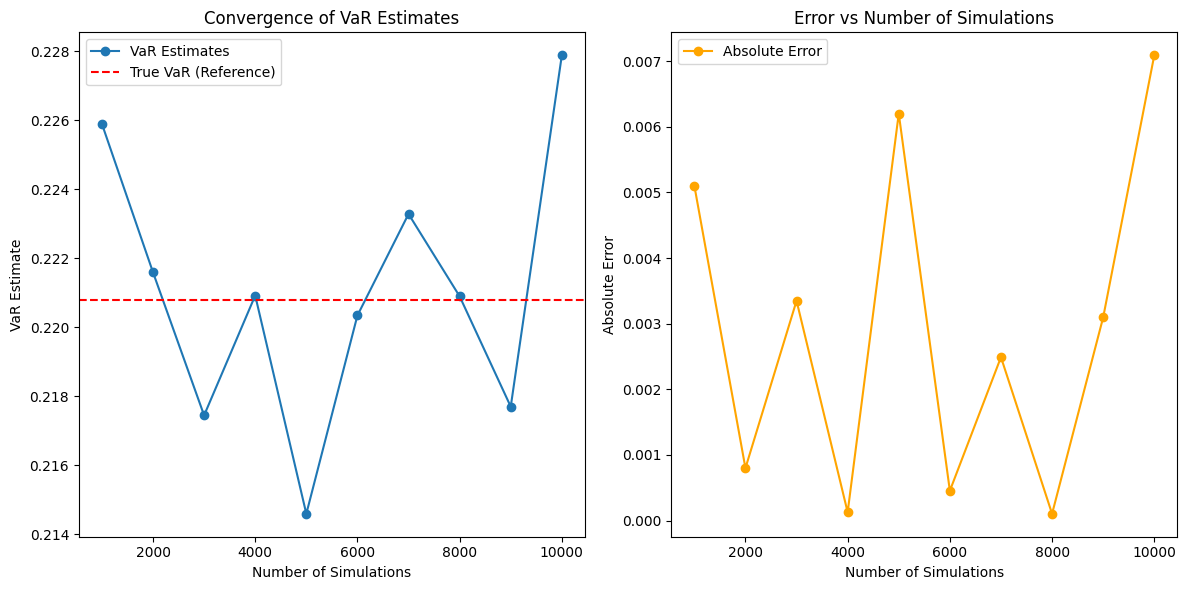

In [20]:
S0 = 100  # Initial stock price
mu = 0.1  # Annual return (drift)
sigma = 0.2  # Annual volatility
T = 1  # 1 year)
n_steps = 252  # Trading days in a year)
confidence = 95  # Level for VaR

# Range of simulations to test
n_simulations_list = [1000*i for i in range(1,11)]


# Value at Risk (VaR)

def compute_var(returns, confidence):
    percentile = 100 - confidence
    var = -np.percentile(returns, percentile)
    return var

# Convergence Analysis

# - We will simulate GBM paths for different numbers of simulations
#   and compute the VaR at each step to study convergence.
# - We will also compute the error relative to a "true" VaR estimate
#   (calculated using a large number of simulations).

# Compute "true" VaR using a large number of simulations 
true_var = compute_var(compute_returns(simulate_gbm(S0, mu, sigma, t, 1000000)), confidence)

# Lists to store results
var_estimates = []  # VaR estimates
errors = []  # Absolute errors

# Perform simulations and compute VaR for each number  of simulations
for n_simulations in n_simulations_list:
    # GBM paths
    paths = simulate_gbm(S0, mu, sigma, t, n_simulations)
    # Compute returns
    returns = compute_returns(paths)
    # Compute VaR
    var = compute_var(returns, confidence)
    # Store results
    var_estimates.append(var)
    errors.append(abs(var - true_var))

# Results
plt.figure(figsize=(12, 6))

# VaR estimates vs number of simulations
plt.subplot(1, 2, 1)
plt.plot(n_simulations_list, var_estimates, marker='o', label='VaR Estimates')
plt.axhline(y=true_var, color='r', linestyle='--', label='True VaR (Reference)')
plt.xlabel('Number of Simulations')
plt.ylabel('VaR Estimate')
plt.title('Convergence of VaR Estimates')
plt.legend()

# Error vs number of simulations
plt.subplot(1, 2, 2)
plt.plot(n_simulations_list, errors, marker='o', color='orange', label='Absolute Error')
plt.xlabel('Number of Simulations')
plt.ylabel('Absolute Error')
plt.title('Error vs Number of Simulations')
plt.legend()

plt.tight_layout()
plt.show()


## Rubric (Total: 100 Points)

| Criteria | Excellent (20) | Good (15) | Fair (10) | Poor (5) |
|----------|--------------|----------|---------|-------|
| **Step 1: Data Initialization** | PRNG and QRNG correctly implemented and analyzed | Minor issues in implementation | Incomplete or incorrect implementation | Little to no effort |
| **Step 2: Monte Carlo Stock Simulation** | GBM correctly simulated and visualized | Small inaccuracies | Major issues in simulation | No proper implementation |
| **Step 3: VaR Estimation** | VaR correctly computed with all methods | Minor computational errors | Missing one key method | Poor implementation |
| **Step 4: Taylor Series Approximation** | Taylor expansion correctly used and compared | Some approximation issues | Incorrect implementation | Not attempted |
| **Step 5: Convergence Analysis & Report** | Convergence studied with clear insights | Minor inconsistencies in analysis | Weak discussion | No analysis provided |

## Submission Guidelines

- Submit a Jupyter Notebook (`.ipynb`) with well-commented code and visualizations.
- Include a short report summarizing findings and observations.
- Ensure reproducibility by setting random seeds where applicable.

## Bonus Challenge

- Implement a risk-adjusted portfolio optimization strategy using Monte Carlo results.
- Compare performance with standard VaR estimation.

This project provides a structured, hands-on experience in financial risk modeling using Monte Carlo simulations. It integrates multiple numerical techniques, ensuring practical application and computational efficiency.